# Visualizing travel time in Boston

source: http://andreacuttone.com/visualizing-travel-time-boston.html

In [12]:
import pandas as pd
import pylab as plt
import numpy as np
import geoplotlib
from geoplotlib.utils import BoundingBox
import shapefile
import pickle
from sklearn.neighbors import KDTree
from shapely.geometry import Point, Polygon
from shapely.ops import cascaded_union
from shapely.prepared import prep


%matplotlib inline
plt.rcParams['figure.figsize'] = (17.0, 9.0)

In [2]:
def print_status(msg):
    from IPython.display import clear_output
    import sys
    clear_output()
    print msg
    sys.stdout.flush()

load the raw travel time data

In [3]:
df = pd.read_csv('boston.csv')

plot the raw samples

(42.303434000000003, 42.418742999999999)

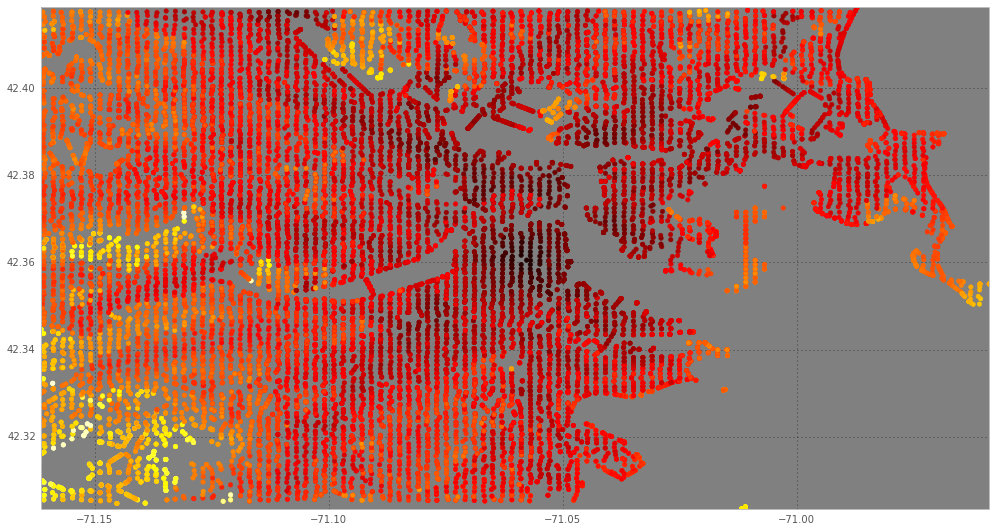

In [4]:
cmap = plt.get_cmap('hot')
col = [cmap(1.*t/df.duration.max()) for t in df.duration]
plt.subplot(111, axisbg='gray')
plt.scatter(df.end_lon, df.end_lat, color=col)
plt.xlim(df.end_lon.min(), df.end_lon.max())
plt.ylim(df.end_lat.min(), df.end_lat.max())

In [5]:
def geodetic2ecef(lat, lon, alt):
    """Convert geodetic coordinates to ECEF."""
    a = 6378.137
    b = 6356.7523142
    esq = 6.69437999014 * 0.001

    lat, lon = np.radians(lat), np.radians(lon)
    sinlat = np.sin(lat)
    coslat = np.cos(lat)
    xi = np.sqrt(1 - esq * sinlat)
    x = 1000 * (a / xi + alt) * coslat * np.cos(lon)
    y = 1000 * (a / xi + alt) * coslat * np.sin(lon)
    z = 1000 * (a / xi * (1 - esq) + alt) * sinlat
    return np.vstack((x, y, z)).T

build the KDTree on ECEF distances

In [6]:
ecef = geodetic2ecef(df.end_lat, df.end_lon, np.zeros(len(df)))

In [7]:
tree = KDTree(ecef)

define an approximately uniform grid over the map

In [17]:
deltalon = 1e-3
deltalat = deltalon/2

lat_edges = np.arange(df.end_lat.min(), df.end_lat.max(), deltalat)
lon_edges = np.arange(df.end_lon.min(), df.end_lon.max(), deltalon)

print len(lat_edges), len(lon_edges)

231 203


load the land masses shapefiles and build a single polygon

In [10]:
sf = shapefile.Reader("boston_massachusetts.land.coastline/boston_massachusetts_land_coast.shp")
shapes = [Polygon(shape.points) for shape in sf.iterShapes()]

In [13]:
bigshape = cascaded_union(shapes)
prepared_polygon = prep(bigshape)

interpolation: for each point in the map, find the neighbors in a 500 meters radius, and apply the Inverse Distance Weighting formula

In [14]:
Z = np.empty((len(lat_edges),len(lon_edges)))
Z[:] = np.nan

c = 0
for row, lat in enumerate(lat_edges):
    for col, lon in enumerate(lon_edges):
        if c % 1000 == 0:
            print_status('%.5f' % (100.*c/(len(lat_edges)*len(lon_edges))))
        c += 1
        if prepared_polygon.contains(Point(lon,lat)):
            idx, d = tree.query_radius(geodetic2ecef(lat,lon,0), 500, return_distance=True)
            if len(idx) > 0:
                w = 1./d[0]**2
                Z[row,col] = (w * df.ix[idx[0]].duration).sum()/w.sum()

98.09566


countour plot

(42.303434000000003, 42.418742999999999)

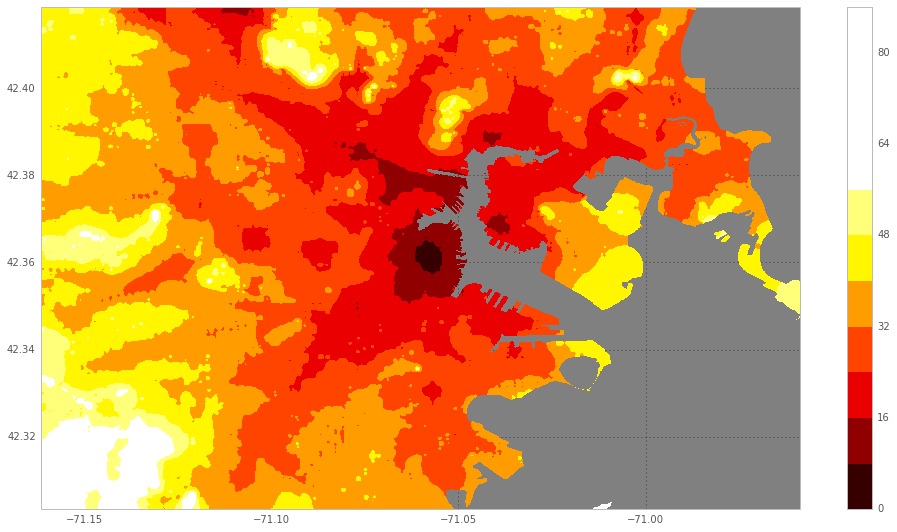

In [24]:
plt.subplot(111, axisbg='gray')
plt.contourf(lon_edges, lat_edges, Z/60, 12, origin='lower', interpolation='none', cmap='hot', vmax=60)
plt.colorbar()

plt.xlim(df.end_lon.min(), df.end_lon.max())
plt.ylim(df.end_lat.min(), df.end_lat.max())

plot on a map

In [20]:
geoplotlib.tiles_provider('positron')
geoplotlib.set_map_alpha(128)
geoplotlib.grid(lon_edges, lat_edges, Z/60, 'hot', alpha=90, vmax=60, levels=12)
geoplotlib.request_zoom(13)
geoplotlib.inline()